# Lecture 4
_____________

## _Simulation Model_

In [1]:
# if running on Colab, copy data from Github
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/jdherman/eci273.git
    %cd eci273

Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

Simplified reservoir simulation for Oroville

In [3]:
# this function should be general to any system
# input capacity, demand (constant), and inflow array
# returns reliability
def simulate(K, D, Q):
  T = len(Q)
  S = np.zeros(T)
  R = np.zeros(T)

  S[0] = K # start simulation full
  R[0] = D
  spill = np.zeros(T)
  met_demand = 1

  for t in range(1,T):
      
    spill[t-1] = max(S[t-1] + Q[t-1] - R[t-1] - K, 0)
    S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

    if S[t] + Q[t] > D:
      R[t] = D
      met_demand += 1
    else:
      R[t] = S[t] + Q[t]

  return met_demand / T


In [4]:
K = 3500 # capacity, TAF
D = 300 # target demand, TAF/month;
Q = np.loadtxt('data/FTO-FNF.csv', delimiter=',', skiprows=1, usecols=[1])
Q /= 1000
T = len(Q)

reliability = simulate(K,D,Q)
print(reliability)

0.9340579710144927


----------

## _Reliability-capacity curve_

In [5]:

K = np.arange(0,10000,100) # make an array of storage values: 0 to 10000 in steps of 100
reliability = np.zeros(len(K)) # we'll calculate these for each K

for i in range(len(K)):
    reliability[i] = simulate(K[i], D, Q)

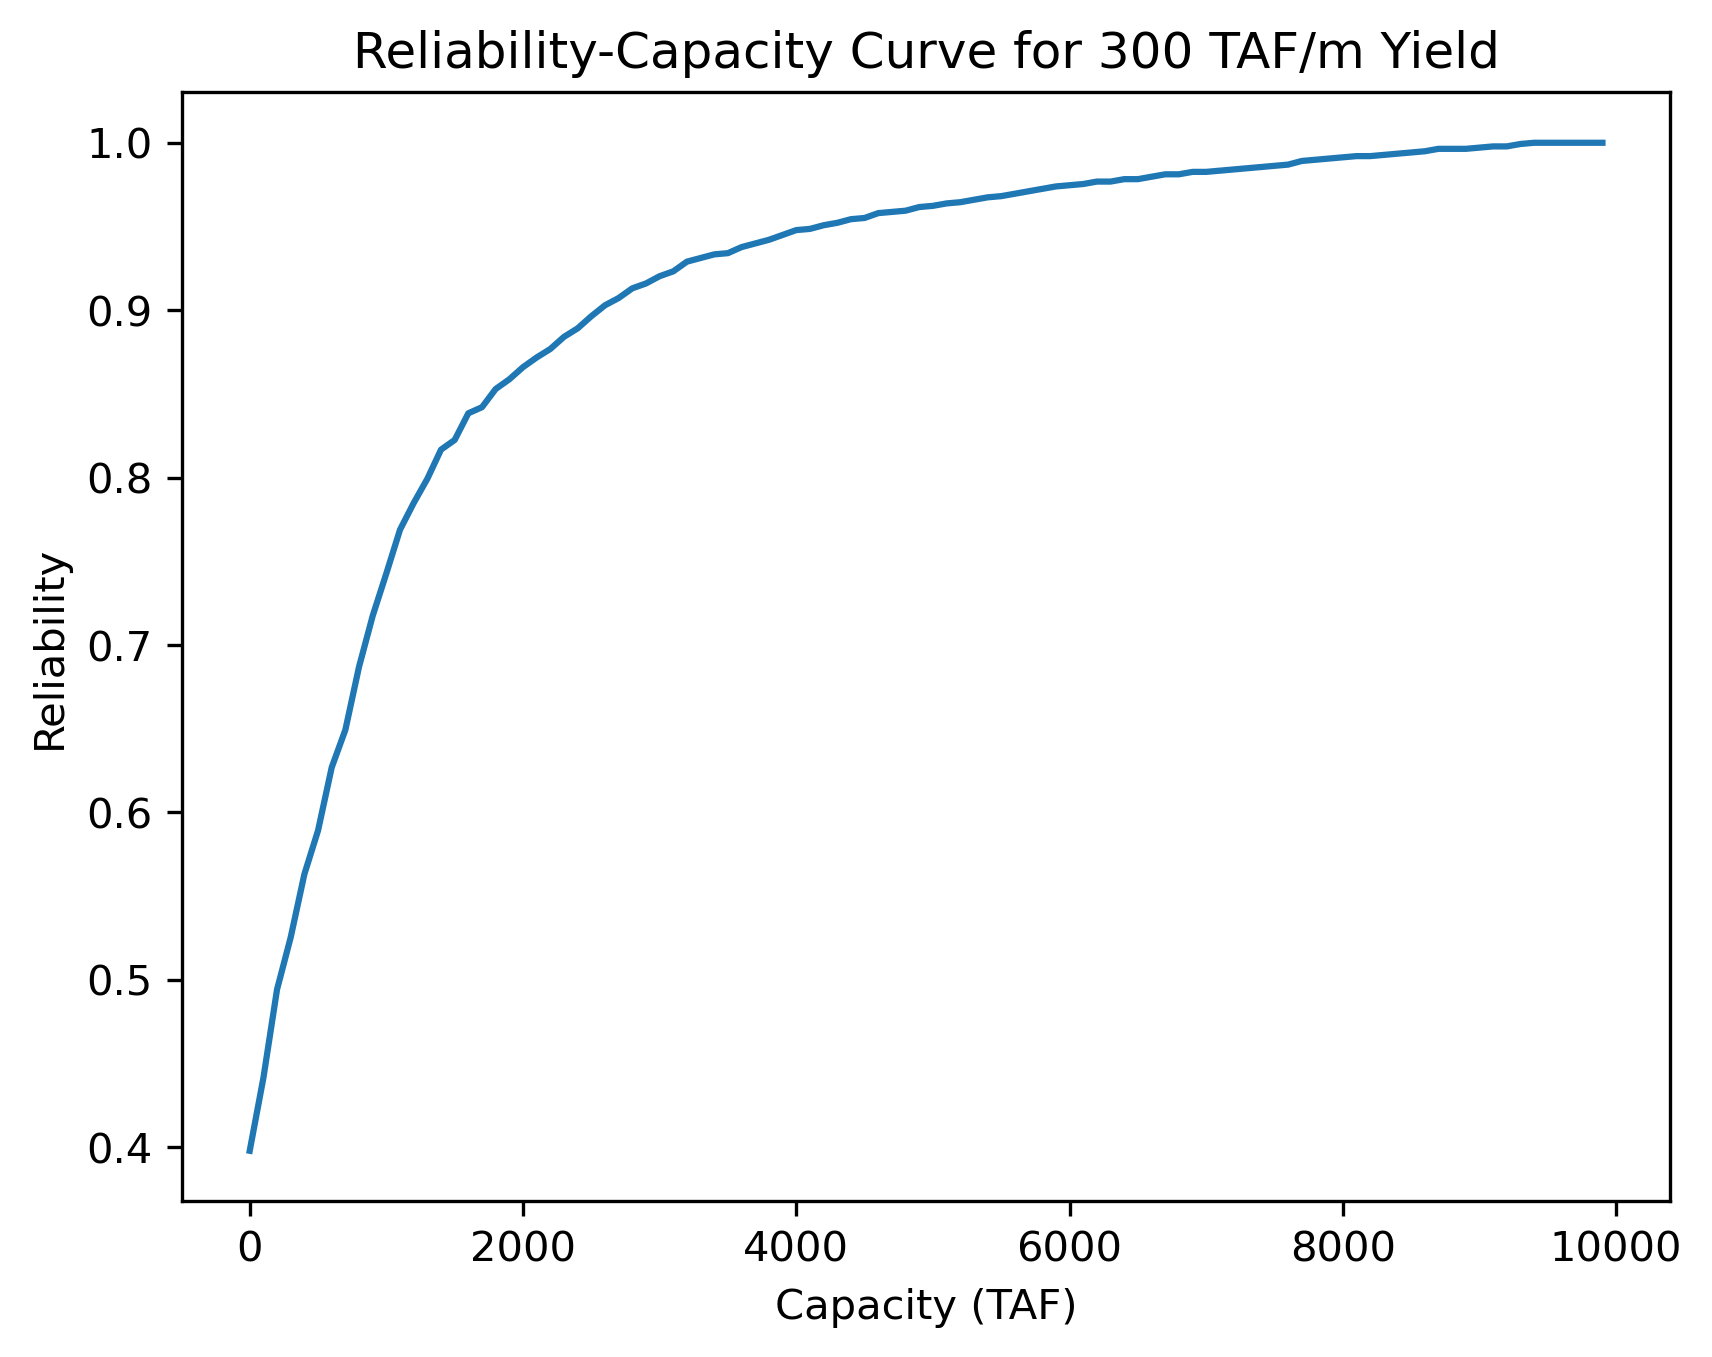

In [6]:
plt.plot(K, reliability)
plt.xlabel('Capacity (TAF)') # K
plt.ylabel('Reliability')
plt.title('Reliability-Capacity Curve for 300 TAF/m Yield')
plt.show()

-----------

## _Delivery reliability curve_

Data setup

In [7]:

D = np.arange(0,1000,50) # make an array of demand values

reliability = np.zeros(len(D)) # we'll calculate these for each demand

Plot a curve for different fixed storage amounts

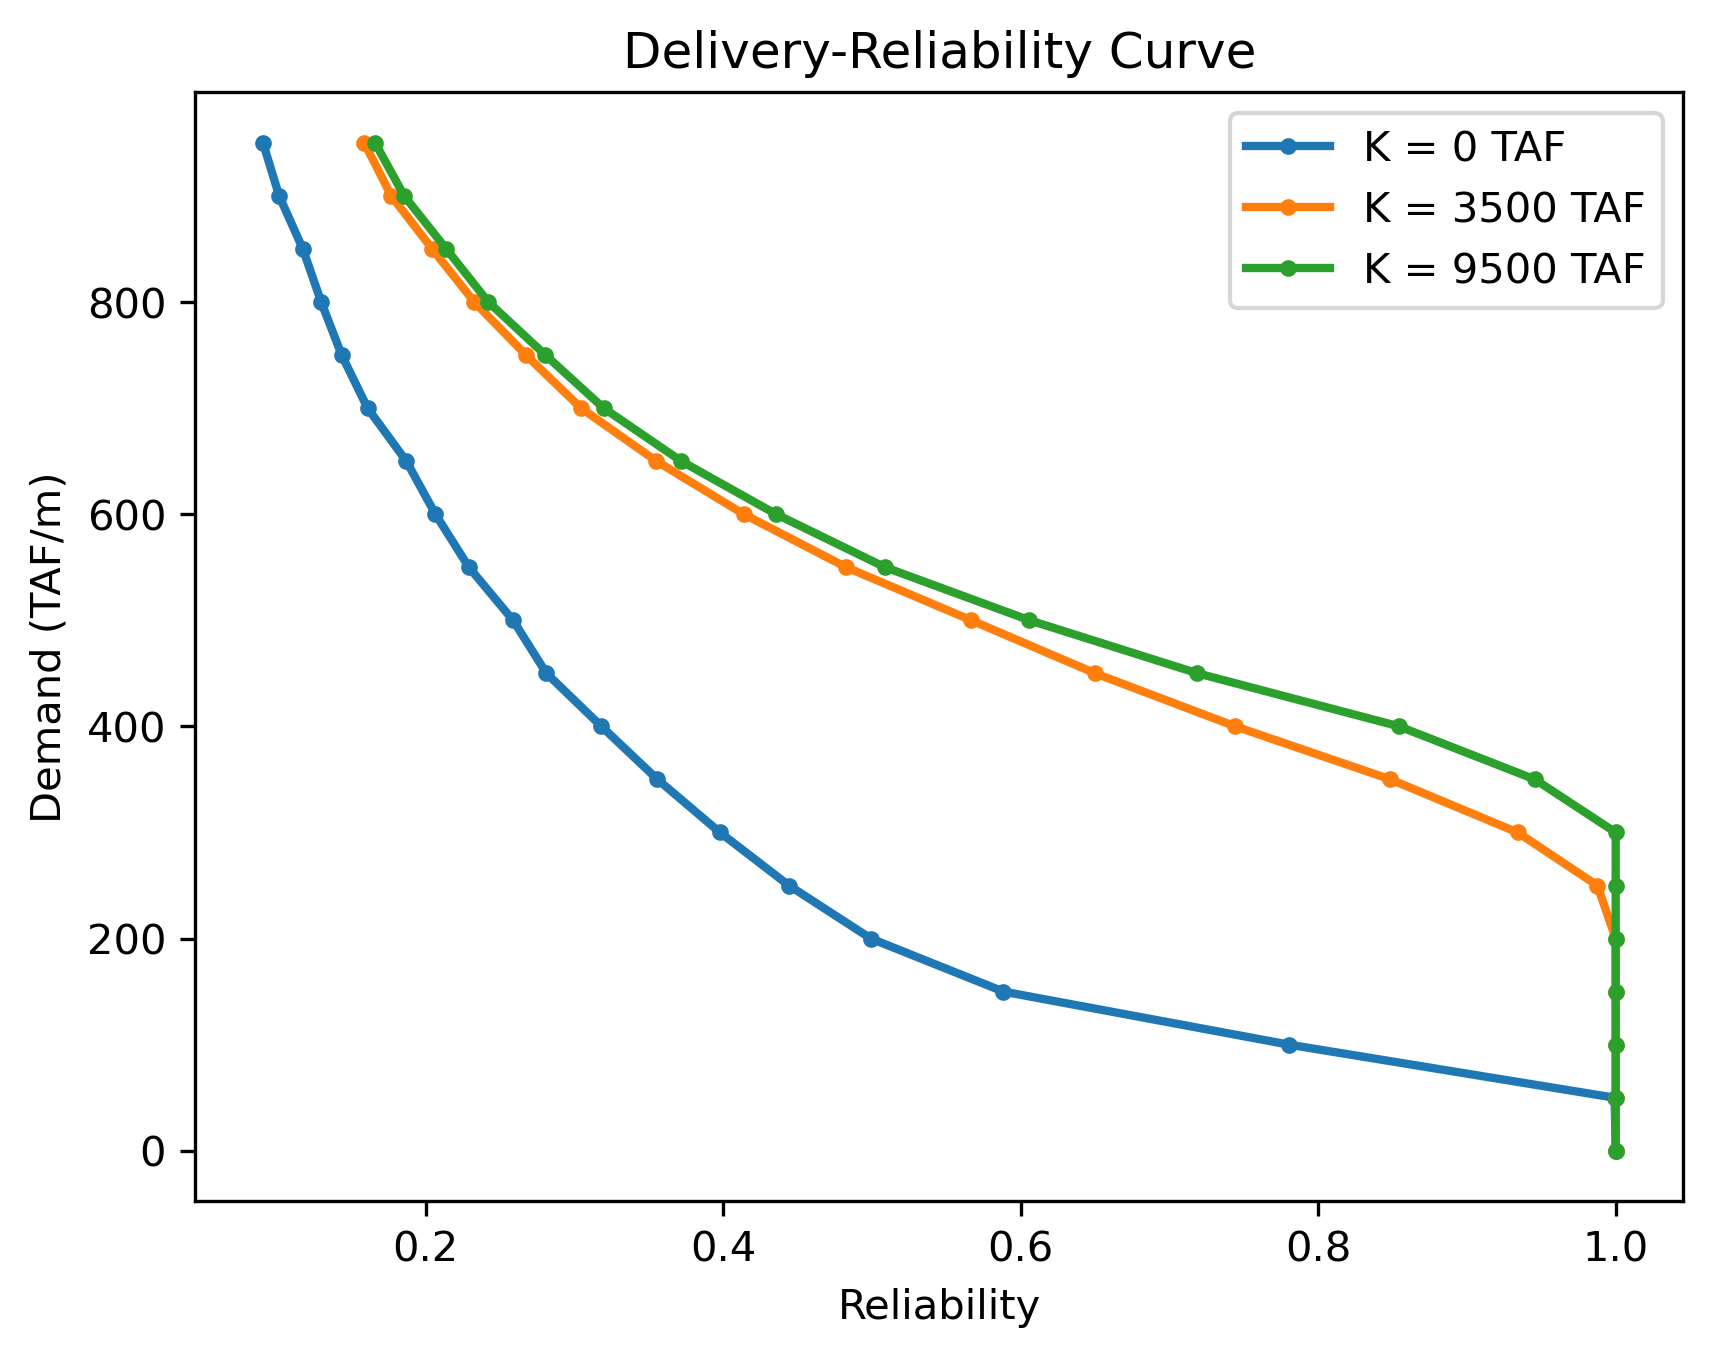

In [8]:
for K in [0, 3500, 9500]:
    for i in range(len(D)):
        reliability[i] = simulate(K, D[i], Q)
    
    plt.plot(reliability, D, '.-', linewidth=2)

plt.xlabel('Reliability')
plt.ylabel('Demand (TAF/m)') # D
plt.title('Delivery-Reliability Curve')
plt.legend(['K = 0 TAF', 'K = 3500 TAF', 'K = 9500 TAF']) # 0 capacity, current capacity, high capacity
plt.show()

-----

## _Storage-Reliability-Yield relationship_

Sequent Peak function from last class

In [9]:
def sequent_peak(R, Q): # for sequent_peak, R is the release/demand we're trying to meet
    T = len(Q)
    K = np.zeros(T+1)
    for t in range(T):
        K[t+1] = max(R[t] - Q[t] + K[t], 0)
    return np.max(K)

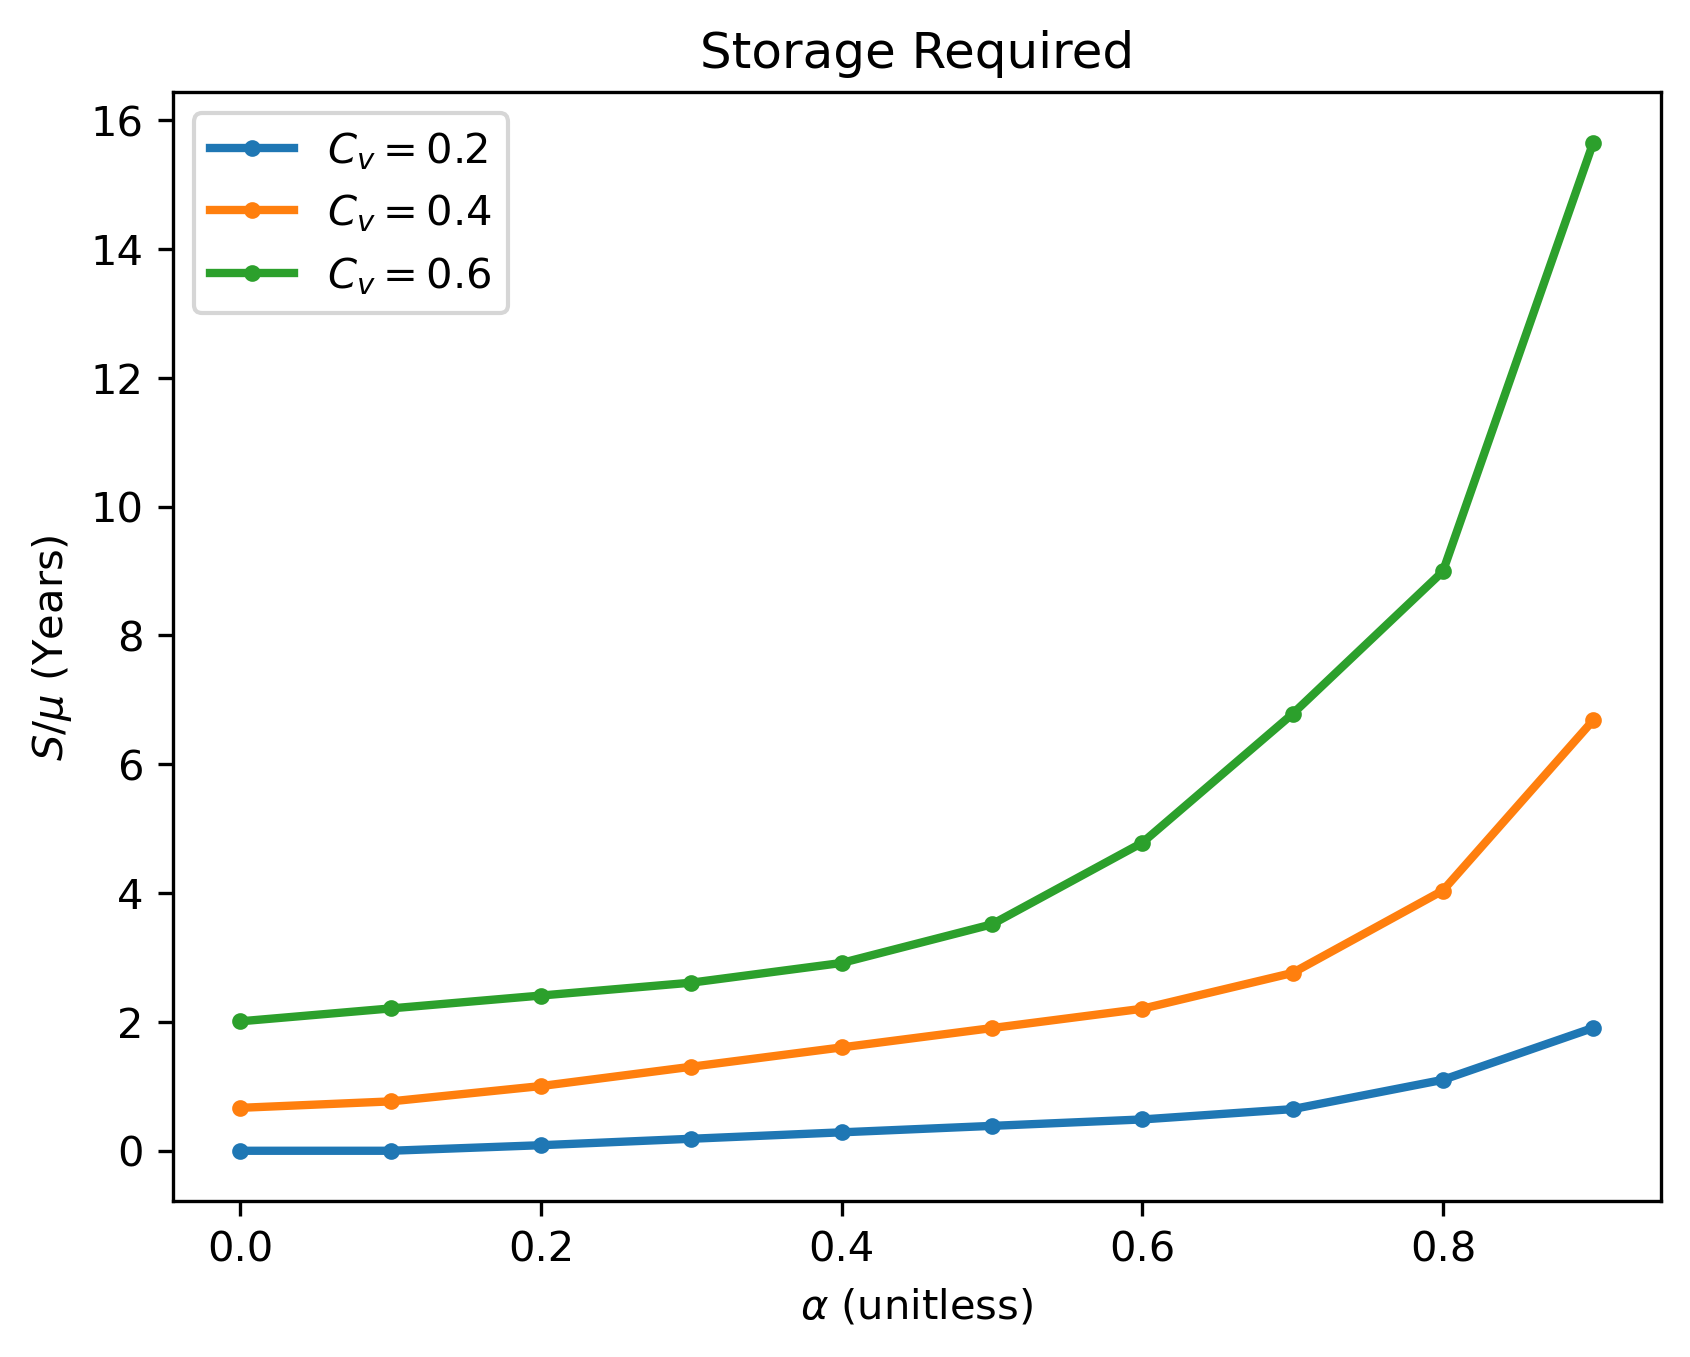

In [10]:
mu = 1 # average annual flow (value should not change the results)
N = 100000 # streamflow sample size - arbitrary large number
alphas = np.arange(0.0, 1.0, 0.1) # demand normalized by average inflow
Ks = np.zeros(len(alphas)) # array of capacity values

for sigma in mu*np.array([0.2, 0.4, 0.6]): # values tested are 20%, 40% and 60%
    inflows = np.random.normal(mu, sigma, size=N) # random sample of normally distributed random values
    
    for i,alpha in enumerate(alphas):
        demand = alpha * mu * np.ones(N) # the demand and inflows are both arrays of length N
        Ks[i] = sequent_peak(demand, inflows) / mu
    
    plt.plot(alphas, Ks, '.-', linewidth=2)

plt.title('Storage Required') # normalized storage
plt.ylabel(r'$S / \mu$ (Years)') # TeX in $_$
plt.xlabel(r'$\alpha$ (unitless)') # normalized demand as a fraction of inflow, unitless
plt.legend([r'$C_v = 0.2$', r'$C_v = 0.4$', r'$C_v = 0.6$'])
plt.show()

When the inflow variation $C_v$ is high, more storage is needed to meet the same demand. The inflows are randomly sampled, so the plot could look a bit different each run. 

Where would Oroville be on this graph? We had a firm yield of 230 TAF/month. This comparison needs to be annual data, and it's easier to use pandas resampling for that.

In [11]:
import pandas as pd
df = pd.read_csv('data/FTO-FNF.csv', index_col=0, parse_dates=True)
df = df.resample('YS-OCT').sum() / 1000 # TAF / year
Q = df.values
firm_yield = 230 * 12 # TAF / year

alpha = firm_yield / Q.mean()
cv = Q.std() / Q.mean()
print('alpha: %0.2f' % alpha)
print('cv: %0.2f' % cv)
print('S/mu: %0.2f' % (3500 / Q.mean()))

alpha: 0.62
cv: 0.48
S/mu: 0.79


For this value of $\alpha$ and $C_v$, the graph above would predict $S/\mu$ around 2 years. Our value was lower. The difference could be that the observed inflows are not normally distributed.

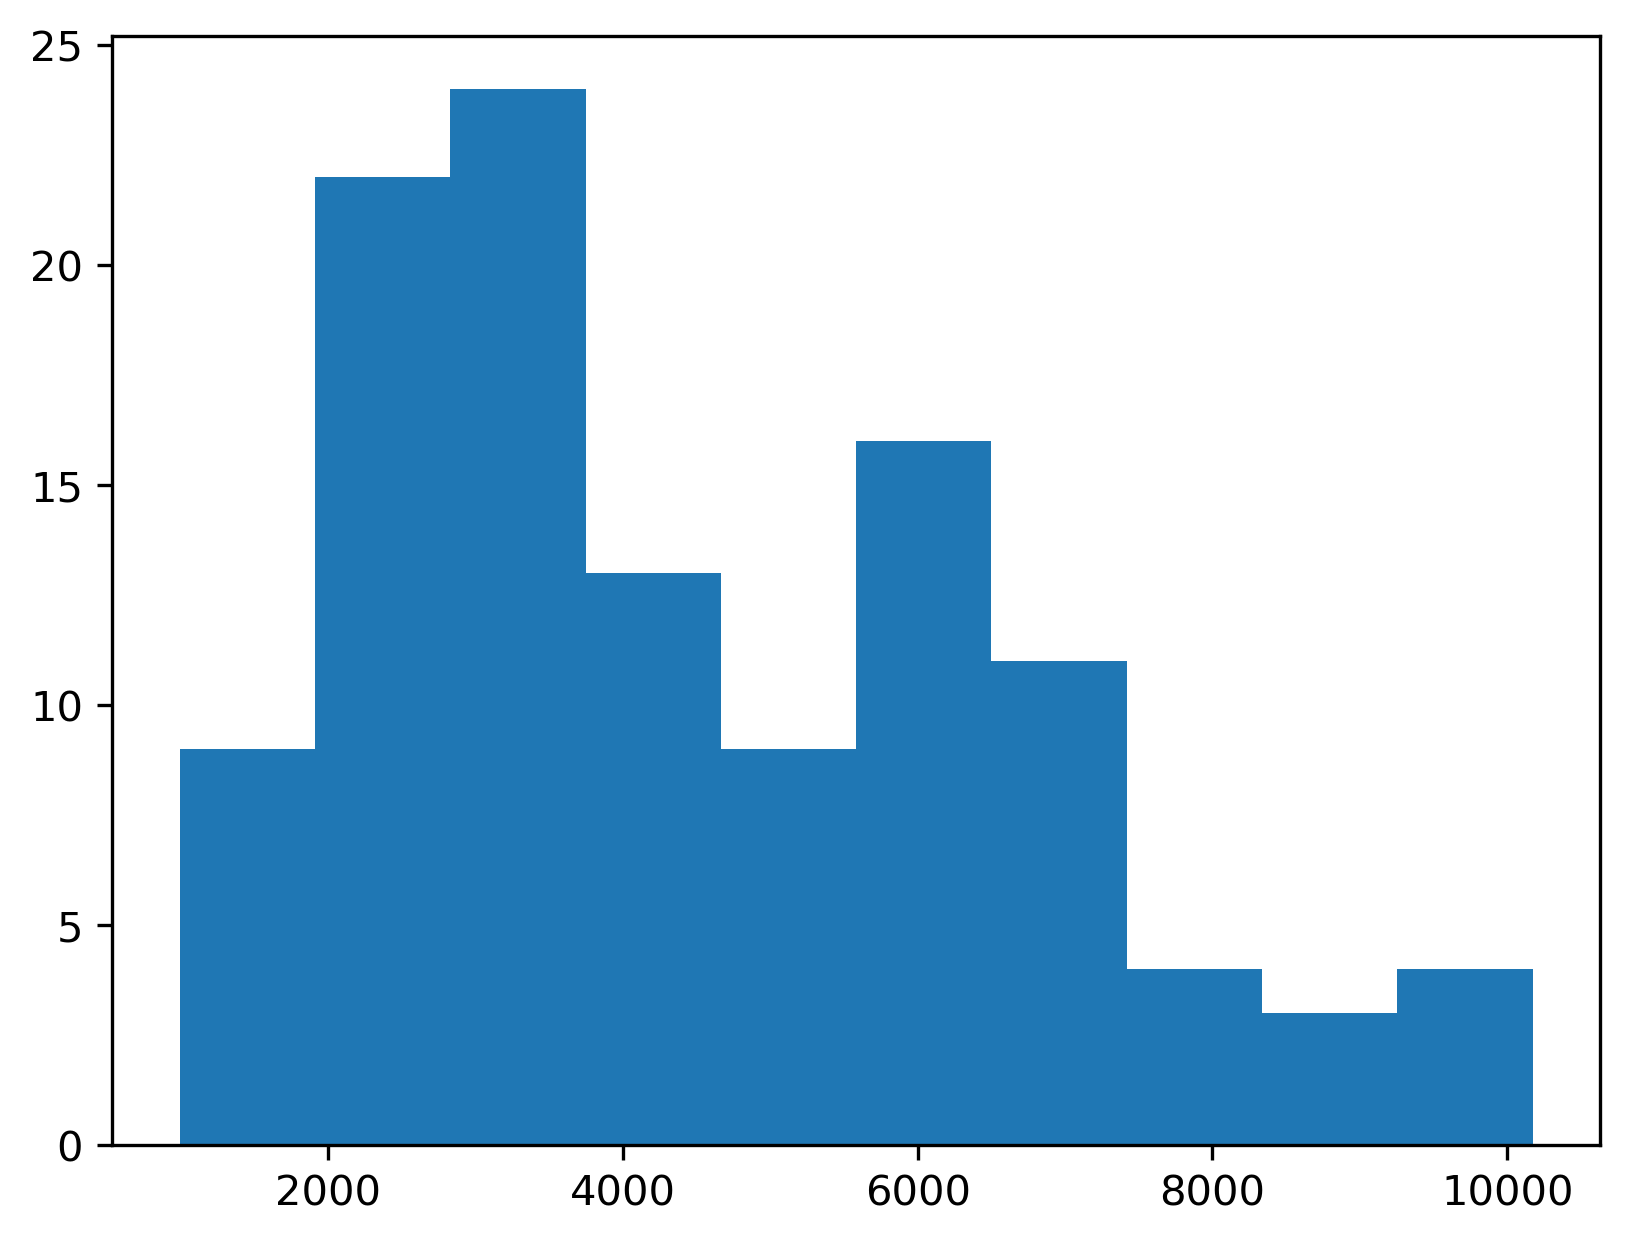

In [12]:
plt.hist(Q)
plt.show()